In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/NIR/ods_broadcasts_201905301157.csv.zip" /content/ods_broadcasts_201905301157.csv.zip
!cp "/content/drive/MyDrive/NIR/ods_match_news.csv.zip" /content/ods_match_news.csv.zip
!unzip /content/ods_broadcasts_201905301157.csv.zip
!unzip /content/ods_match_news.csv.zip

Archive:  /content/ods_broadcasts_201905301157.csv.zip
  inflating: ods_broadcasts_201905301157.csv  
Archive:  /content/ods_match_news.csv.zip
  inflating: ods_match_news.csv      


In [ ]:
import pandas as pd
import numpy as np
import nltk
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

#### Загрузка данных и предварительный анализ

##### Набор данных текстовых трансляций

In [ ]:
data_broadcasts = pd.read_csv("/content/ods_broadcasts_201905301157.csv")
data_broadcasts

,match_id,team1,team2,name,match_time,type,minute,content,message_time
0,18925,Локомотив,Химки,Россия. Премьер-лига,1237037400,NaN,0,"Добрый день! Sports.ru поздравляет всех, кто п...",1237034763
1,18925,Локомотив,Химки,Россия. Премьер-лига,1237037400,NaN,0,"Будем надеяться, что признаков пресловутого ""в...",1237034996
2,18925,Локомотив,Химки,Россия. Премьер-лига,1237037400,NaN,0,"Что ж, сегодняшних соперников можно назвать од...",1237035202
3,18925,Локомотив,Химки,Россия. Премьер-лига,1237037400,NaN,0,Зимой подмосковный клуб едва не исчез с футбол...,1237035415
4,18925,Локомотив,Химки,Россия. Премьер-лига,1237037400,NaN,0,"""Локомотив"" зимой старался стать лучше. В сост...",1237035796
...,...,...,...,...,...,...,...,...,...
722062,1104866,Питтсбург,Сан-Хосе,Кубок Стэнли,1464825600,empty,63,"<b>2:1 - ""Питтсбург"" выигрывает второй финальн...",1464837758
722063,1104866,Питтсбург,Сан-Хосе,Кубок Стэнли,1464825600,empty,63,"Очевидно, что залог успеха ""Питтсбурга"" - иниц...",1464837879
722064,1104866,Питтсбург,Сан-Хосе,Кубок Стэнли,1464825600,empty,63,"Другими словами, ДеБур должен в первую очередь...",1464838029
722065,1104866,Питтсбург,Сан-Хосе,Кубок Стэнли,1464825600,empty,63,Большое спасибо за чтение! До новых встреч на ...,1464838220


In [ ]:
data_broadcasts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 722067 entries, 0 to 722066
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   match_id      722067 non-null  int64 
 1   team1         722067 non-null  object
 2   team2         722067 non-null  object
 3   name          722067 non-null  object
 4   match_time    722067 non-null  int64 
 5   type          542930 non-null  object
 6   minute        722067 non-null  int64 
 7   content       721636 non-null  object
 8   message_time  722067 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 49.6+ MB


В наборе данных текстовые трансляции разделены по минутам. Сгруппируем данные для получения полных трансляций.

In [ ]:
def concatenate_content(messages):
  return ' '.join([str(message).strip() for message in messages])

grouping_columns = ['match_id', 'team1', 'team2', 'name', 'match_time']
data_broadcasts = data_broadcasts.sort_values(['match_id', 'minute', 'message_time'], ascending = True).groupby(grouping_columns)['content'].apply(concatenate_content).reset_index()
data_broadcasts

,match_id,team1,team2,name,match_time,content
0,18925,Локомотив,Химки,Россия. Премьер-лига,1237037400,"Добрый день! Sports.ru поздравляет всех, кто п..."
1,18935,Зенит,Штутгарт,перенесенные матчи,1234977300,"Матчем со ""Штутгартом"" ""Зенит"" открывает европ..."
2,18936,Астон Вилла,ЦСКА,перенесенные матчи,1234983600,"Интересный парадокс жребия - армейцам, единств..."
3,18941,Шахтер,Тоттенхэм,перенесенные матчи,1235069100,Приветствуем Всех любителей самой популярной и...
4,18956,Штутгарт,Зенит,перенесенные матчи,1235677500,"Ответный матч 1/16 финала Кубка УЕФА ""Зенита"" ..."
...,...,...,...,...,...,...
8776,1104438,Томь,Кубань,Россия. Премьер-лига,1464354000,Привет. Теперь точно – сегодня последний тур Р...
8777,1104439,Волгарь,Анжи,Россия. Премьер-лига,1464102000,Всем привет! Стыковые матчи за право выступать...
8778,1104440,Анжи,Волгарь,Россия. Премьер-лига,1464364800,Всем привет! Сегодня важный день для российско...
8779,1104865,Питтсбург,Сан-Хосе,Кубок Стэнли,1464652800,"Привет всем, кто не представляет своей жизни б..."


In [ ]:
data_broadcasts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8781 entries, 0 to 8780
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   match_id    8781 non-null   int64 
 1   team1       8781 non-null   object
 2   team2       8781 non-null   object
 3   name        8781 non-null   object
 4   match_time  8781 non-null   int64 
 5   content     8781 non-null   object
dtypes: int64(2), object(4)
memory usage: 411.7+ KB


In [ ]:
# Пример текстовой трансляции
data_broadcasts.iloc[8779]['content']

'Привет всем, кто не представляет своей жизни без хоккея! Центрфорвард Евгений Малкин - единственный представитель России в паре "пингвинов" и "акул". Мог быть еще Сергей Плотников, но был по ходу сезона отправлен в "Аризону", в составе которой так и не смог открыть счет своим голам в НХЛ. Финал Кубка Стэнли-2016 стартует в ночь на 31 мая по Москве. Sports.ru не может пройти мимо этого события и осветит его в подробностях. Кстати, в фарм-клубе "Питтсбурга" засветился в этом сезоне еще один представитель России - форвард Антон Злобин, герой финала Мемориального Кубка-2012. Но, похоже, его карьерная дорога все дальше и дальше отклоняется от НХЛ. Так что о российской тройке в "Питтсбурге" остается только мечтать. Есть примеры и обратного свойства, и примеры удивительные. Фарм-клуб "Питтсбурга" стал одной из главных причин успешного выступления основной команды в концовке сезона и в плей-офф.  Отдача совершенно поразительная. Нападающие Коннор Шери, Брайан Раст, Том Кюнхакль, вратарь Мэтт 

Необходимо удалить html-разметку из текстовых трансляций

In [ ]:
def remove_tags(html):
    soup = BeautifulSoup(html, "html.parser")
    
    for data in soup(['style', 'script']):
        data.decompose()

    return ' '.join(soup.stripped_strings)

data_broadcasts['content'] = data_broadcasts['content'].apply(remove_tags)

<ipython-input-9-1775241e2dc0>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(html, "html.parser")


In [ ]:
data_broadcasts.iloc[8779]['content']

'Привет всем, кто не представляет своей жизни без хоккея! Центрфорвард Евгений Малкин - единственный представитель России в паре "пингвинов" и "акул". Мог быть еще Сергей Плотников, но был по ходу сезона отправлен в "Аризону", в составе которой так и не смог открыть счет своим голам в НХЛ. Финал Кубка Стэнли-2016 стартует в ночь на 31 мая по Москве. Sports.ru не может пройти мимо этого события и осветит его в подробностях. Кстати, в фарм-клубе "Питтсбурга" засветился в этом сезоне еще один представитель России - форвард Антон Злобин, герой финала Мемориального Кубка-2012. Но, похоже, его карьерная дорога все дальше и дальше отклоняется от НХЛ. Так что о российской тройке в "Питтсбурге" остается только мечтать. Есть примеры и обратного свойства, и примеры удивительные. Фарм-клуб "Питтсбурга" стал одной из главных причин успешного выступления основной команды в концовке сезона и в плей-офф.  Отдача совершенно поразительная. Нападающие Коннор Шери, Брайан Раст, Том Кюнхакль, вратарь Мэтт 

In [ ]:
stop_words = set(stopwords.words('russian'))

counter = Counter()
for text in data_broadcasts['content'].values:
  for word in word_tokenize(text.lower()):
    if word not in stop_words:
      counter[word] += 1

In [ ]:
most_common = counter.most_common(100)
most_common

[('.', 953586),
 (',', 823157),
 ('!', 356825),
 ('``', 262999),
 ("''", 262850),
 ('-', 151695),
 ('мяч', 96179),
 (':', 48118),
 ('штрафной', 45307),
 ('это', 38774),
 ('ворот', 32794),
 (')', 30433),
 ('удар', 29577),
 ('...', 27903),
 ('очень', 27895),
 ('(', 26596),
 ('пока', 25733),
 ('?', 25555),
 ('вместо', 24535),
 ('сегодня', 21664),
 ('шайбу', 20721),
 ('матч', 20457),
 ('штрафную', 19158),
 ('гол', 18858),
 ('ворота', 18837),
 ('угол', 18764),
 ('команды', 17692),
 ('поля', 17689),
 ('пробил', 16922),
 ('снова', 16871),
 ('момент', 16375),
 ('поле', 16252),
 ('который', 16218),
 ('линии', 15816),
 ('пас', 15708),
 ('гостей', 15688),
 ('хозяев', 15439),
 ('второй', 14981),
 ('воротам', 14910),
 ('метров', 14874),
 ('игру', 14441),
 ('соперника', 14347),
 ('створ', 14290),
 ('угловой', 14201),
 ('динамо', 13879),
 ('бросок', 13763),
 ('минуты', 13755),
 ('своей', 13377),
 ('матча', 13301),
 ('игра', 13083),
 ('«', 12798),
 ('»', 12798),
 ('первый', 12759),
 ('хозяева', 12757)

##### Набор данных новостей

In [ ]:
data_news = pd.read_csv('/content/ods_match_news.csv')
data_news

,id,name,ctime,body,match_id
0,7005921,Зико: &laquo;Задача может быть только одна: пр...,2009-02-18 01:06:26,<p>Главный тренер ЦСКА Зико поделился мыслями ...,18936
1,7005943,Текстовые онлайны матчей &#171;Зенит&#187; &#1...,2009-02-18 01:08:20,<p>Сегодня на Sports.ru дебютируют текстовые о...,18935
2,7005943,Текстовые онлайны матчей &#171;Зенит&#187; &#1...,2009-02-18 01:08:20,<p>Сегодня на Sports.ru дебютируют текстовые о...,18936
3,7006022,Стилян Петров: &laquo;ЦСКА выиграл все матчи в...,2009-02-18 01:21:55,<p>Полузащитник &#171;Астон Виллы&#187; Стилян...,18936
4,7006398,Хиддинк постетит матч &laquo;Астон Виллы&raquo...,2009-02-18 03:17:23,<p>Главный тренер сборной России и &#171;Челси...,18936
...,...,...,...,...,...
92992,1040645221,Петр Чех: Если бы пропустил от Денисова — это ...,2016-06-02 14:44:24,"<p class=""text"">Голкипер сборной Чехии Петр Че...",1095139
92993,1040648050,"Конор Шери: &laquo;Кросби сказал, что выиграет...",2016-06-02 16:17:07,"<p>Форвард <a class=""link-news2tags"" href=""htt...",1104866
92994,1040648436,Сидни Кросби: &laquo;Победным голом мы больше ...,2016-06-02 16:29:35,"<p>Капитан <a class=""link-news2tags"" href=""htt...",1104866
92995,1040653602,Джастин Браун: &laquo;Питтсбург&raquo; все нас...,2016-06-02 19:36:29,<p>Защитник «Сан-Хосе» Джастин Браун оценил хо...,1104866


In [ ]:
data_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92997 entries, 0 to 92996
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        92997 non-null  int64 
 1   name      92997 non-null  object
 2   ctime     92997 non-null  object
 3   body      92995 non-null  object
 4   match_id  92997 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 3.5+ MB


Необходимо удалить html-разметку из новостей

In [ ]:
# Удалим новости, которые не содержат текста
data_news.dropna(axis=0, how='any', subset=['body'], inplace=True)

data_news['name'] = data_news['name'].apply(remove_tags)
data_news['body'] = data_news['body'].apply(remove_tags)

<ipython-input-9-1775241e2dc0>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(html, "html.parser")


In [ ]:
data_news.iloc[1]['body']

'Сегодня на Sports.ru дебютируют текстовые онлайны матчей Кубка УЕФА , кроме того, на сайте продолжится тестирование трансляций чемпионата Англии . За всеми значимыми событиями (голы, замены, предупреждения и т.д.) всех матчей дня вы сможете следить на страницах онлайнов, обмениваясь по ходу впечатлениями в матч-чате. Попасть на страницы текстовых трансляций вы можете через страницу матч-центра либо с помощью информационного блока непосредственно под главным меню. При этом для трех матчей предусмотрены подробнейшие текстовые трансляции: это «Зенит» \x96 «Штутгарт» (онлайн начинается в 19.45), «Астон Вилла» \x96 ЦСКА (начало \x96 в 21.30) и «Манчестер Юнайтед» \x96 «Фулхэм» (начало \x96 в 22.30). Заранее приносим извинения за возможные на этапе бета-тестирования ошибки и призываем тех, кто их заметил, писать на support@sports.ru.'

In [ ]:
counter_name_news = Counter()
for text in data_news['name'].values:
  for word in word_tokenize(text.lower()):
    if word not in stop_words:
      counter_name_news[word] += 1

In [ ]:
most_common_name = counter_name_news.most_common(100)
most_common_name

[('«', 128708),
 ('»', 127856),
 (':', 64414),
 (',', 45856),
 ('–', 23759),
 ('.', 22894),
 ('матч', 5343),
 ('матче', 5309),
 ('цска', 4614),
 ('динамо', 4204),
 ('александр', 4108),
 ('другие', 3933),
 ('результаты', 3594),
 ('это', 3555),
 ('гол', 3538),
 ('сергей', 3003),
 ('матча', 2881),
 ('зенит', 2851),
 ('спартак', 2710),
 ('победу', 2703),
 ('очень', 2597),
 ('нам', 2467),
 ('играть', 2426),
 ('россии', 2356),
 ('нхл', 2204),
 ('тур', 2119),
 ('забил', 2097),
 ('ска', 2086),
 ('андрей', 1909),
 ('манчестер', 1819),
 ('локомотив', 1806),
 ('сборной', 1787),
 ('против', 1785),
 ('?', 1715),
 ('кхл', 1704),
 ('нужно', 1634),
 ('россия', 1611),
 ('чемпионат', 1603),
 ('игру', 1599),
 ('челси', 1586),
 ('сегодня', 1586),
 ('чемпионов', 1536),
 ('реал', 1535),
 ('—', 1491),
 ('игре', 1487),
 ('евгений', 1483),
 ('валерий', 1473),
 ('дмитрий', 1442),
 ('владимир', 1425),
 ('матчи', 1419),
 ('барселона', 1414),
 ('игра', 1406),
 ('пенальти', 1398),
 ('анжи', 1397),
 ('финала', 1390)

In [ ]:
counter_body_news = Counter()
for text in data_news['body'].values:
  for word in word_tokenize(text.lower()):
    if word not in stop_words:
      counter_body_news[word] += 1

In [ ]:
most_common_body = counter_body_news.most_common(100)
most_common_body

[(',', 907528),
 ('.', 797734),
 ('»', 413924),
 ('«', 413777),
 ('–', 221646),
 (')', 94116),
 ('(', 93960),
 ('это', 69501),
 ('матча', 61872),
 ('?', 55770),
 ('матче', 46303),
 ('очень', 42436),
 ('матч', 39098),
 ('против', 36292),
 ('россии', 32208),
 (':', 31580),
 ('команда', 30189),
 ('тура', 29865),
 ('сегодня', 29713),
 ('тренер', 28646),
 ('сказал', 28645),
 ('чемпионата', 28020),
 ('—', 27844),
 ('нам', 26897),
 ('сборной', 25513),
 ('команды', 24793),
 ('цска', 24242),
 ('играть', 22997),
 ('главный', 22592),
 ('динамо', 22266),
 ('игру', 21766),
 ('игра', 21426),
 ('игры', 20379),
 ('sports.ru', 20269),
 ('поделился', 20084),
 ('лиги', 19950),
 ('-', 18926),
 ('1', 18338),
 ('думаю', 17792),
 ('2', 17698),
 ('цитирует', 17662),
 ('игре', 17198),
 ('нужно', 17021),
 ('чемпионов', 16582),
 ('3', 16449),
 ('\x96', 16371),
 ('время', 16220),
 ('гол', 16086),
 ('4', 16007),
 ('серии', 14467),
 ('кубка', 13898),
 ('5', 13813),
 ('финала', 13420),
 ('счет', 13396),
 ('премьер-л

Необходимо удалить символ \x96 из тела новости

In [ ]:
data_news['body'] = data_news['body'].apply(lambda x: str(x).replace(' \x96', ""))
data_news.iloc[1]['body']

'Сегодня на Sports.ru дебютируют текстовые онлайны матчей Кубка УЕФА , кроме того, на сайте продолжится тестирование трансляций чемпионата Англии . За всеми значимыми событиями (голы, замены, предупреждения и т.д.) всех матчей дня вы сможете следить на страницах онлайнов, обмениваясь по ходу впечатлениями в матч-чате. Попасть на страницы текстовых трансляций вы можете через страницу матч-центра либо с помощью информационного блока непосредственно под главным меню. При этом для трех матчей предусмотрены подробнейшие текстовые трансляции: это «Зенит» «Штутгарт» (онлайн начинается в 19.45), «Астон Вилла» ЦСКА (начало в 21.30) и «Манчестер Юнайтед» «Фулхэм» (начало в 22.30). Заранее приносим извинения за возможные на этапе бета-тестирования ошибки и призываем тех, кто их заметил, писать на support@sports.ru.'

##### Общий набор данных

In [ ]:
data = pd.merge(data_broadcasts, data_news, on="match_id", how="inner")
data.rename(columns = {'name_x' : 'broadcast_name', 'name_y' : 'news_name'}, inplace = True)
data

,match_id,team1,team2,broadcast_name,match_time,content,id,news_name,ctime,body
0,18925,Локомотив,Химки,Россия. Премьер-лига,1237037400,"Добрый день! Sports.ru поздравляет всех, кто п...",7267034,Три тысячи сотрудников милиции будут следить з...,2009-03-13 22:17:53,Более трех тысяч сотрудников столичной милиции...
1,18925,Локомотив,Химки,Россия. Премьер-лига,1237037400,"Добрый день! Sports.ru поздравляет всех, кто п...",7269714,Текстовый онлайн матча «Атлетик» – «Реал» – на...,2009-03-14 03:45:43,Сегодня Sports.ru продолжит текстовые трансляц...
2,18925,Локомотив,Химки,Россия. Премьер-лига,1237037400,"Добрый день! Sports.ru поздравляет всех, кто п...",7270558,Премьер-лига. 1-й тур. «Терек» обыграл «Спарта...,2009-03-14 10:22:27,1-й тур ПРИМЕЧАНИЕ: время начала матчей – моск...
3,18925,Локомотив,Химки,Россия. Премьер-лига,1237037400,"Добрый день! Sports.ru поздравляет всех, кто п...",7274151,Дюрица получил травму в игре с «Химками»,2009-03-14 17:48:18,Защитник «Локомотива» Ян Дюрица получил травму...
4,18925,Локомотив,Химки,Россия. Премьер-лига,1237037400,"Добрый день! Sports.ru поздравляет всех, кто п...",7274661,Константин Сарсания: «Если бы выпустил второго...,2009-03-14 18:34:35,Главный тренер «Химок» Константин Сарсания про...
...,...,...,...,...,...,...,...,...,...,...
92990,1104866,Питтсбург,Сан-Хосе,Кубок Стэнли,1464825600,"Привет всем, кто не представляет своей жизни б...",1040642045,Майк Салливан: «Атака – козырь «Сан-Хосе» и мы...,2016-06-02 12:46:34,Главный тренер «Питтсбурга» Майк Салливан прок...
92991,1104866,Питтсбург,Сан-Хосе,Кубок Стэнли,1464825600,"Привет всем, кто не представляет своей жизни б...",1040648050,"Конор Шери: «Кросби сказал, что выиграет вбрас...",2016-06-02 16:17:07,Форвард «Питтсбурга» Конор Шери прокомментиров...
92992,1104866,Питтсбург,Сан-Хосе,Кубок Стэнли,1464825600,"Привет всем, кто не представляет своей жизни б...",1040648436,Сидни Кросби: «Победным голом мы больше обязан...,2016-06-02 16:29:35,Капитан «Питтсбурга» Сидни Кросби прокомментир...
92993,1104866,Питтсбург,Сан-Хосе,Кубок Стэнли,1464825600,"Привет всем, кто не представляет своей жизни б...",1040653602,Джастин Браун: «Питтсбург» все наступал и наст...,2016-06-02 19:36:29,Защитник «Сан-Хосе» Джастин Браун оценил ход с...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92995 entries, 0 to 92994
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   match_id        92995 non-null  int64 
 1   team1           92995 non-null  object
 2   team2           92995 non-null  object
 3   broadcast_name  92995 non-null  object
 4   match_time      92995 non-null  int64 
 5   content         92995 non-null  object
 6   id              92995 non-null  int64 
 7   news_name       92995 non-null  object
 8   ctime           92995 non-null  object
 9   body            92995 non-null  object
dtypes: int64(3), object(7)
memory usage: 7.8+ MB


Конвертирование типов данных

In [ ]:
data['ctime'] = pd.to_datetime(data['ctime'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
data['match_time'] = data['match_time'].apply(lambda x: dt.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
data['match_time'] = pd.to_datetime(data['match_time'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
data

,match_id,team1,team2,broadcast_name,match_time,content,id,news_name,ctime,body
0,18925,Локомотив,Химки,Россия. Премьер-лига,2009-03-14 13:30:00,"Добрый день! Sports.ru поздравляет всех, кто п...",7267034,Три тысячи сотрудников милиции будут следить з...,2009-03-13 22:17:53,Более трех тысяч сотрудников столичной милиции...
1,18925,Локомотив,Химки,Россия. Премьер-лига,2009-03-14 13:30:00,"Добрый день! Sports.ru поздравляет всех, кто п...",7269714,Текстовый онлайн матча «Атлетик» – «Реал» – на...,2009-03-14 03:45:43,Сегодня Sports.ru продолжит текстовые трансляц...
2,18925,Локомотив,Химки,Россия. Премьер-лига,2009-03-14 13:30:00,"Добрый день! Sports.ru поздравляет всех, кто п...",7270558,Премьер-лига. 1-й тур. «Терек» обыграл «Спарта...,2009-03-14 10:22:27,1-й тур ПРИМЕЧАНИЕ: время начала матчей – моск...
3,18925,Локомотив,Химки,Россия. Премьер-лига,2009-03-14 13:30:00,"Добрый день! Sports.ru поздравляет всех, кто п...",7274151,Дюрица получил травму в игре с «Химками»,2009-03-14 17:48:18,Защитник «Локомотива» Ян Дюрица получил травму...
4,18925,Локомотив,Химки,Россия. Премьер-лига,2009-03-14 13:30:00,"Добрый день! Sports.ru поздравляет всех, кто п...",7274661,Константин Сарсания: «Если бы выпустил второго...,2009-03-14 18:34:35,Главный тренер «Химок» Константин Сарсания про...
...,...,...,...,...,...,...,...,...,...,...
92990,1104866,Питтсбург,Сан-Хосе,Кубок Стэнли,2016-06-02 00:00:00,"Привет всем, кто не представляет своей жизни б...",1040642045,Майк Салливан: «Атака – козырь «Сан-Хосе» и мы...,2016-06-02 12:46:34,Главный тренер «Питтсбурга» Майк Салливан прок...
92991,1104866,Питтсбург,Сан-Хосе,Кубок Стэнли,2016-06-02 00:00:00,"Привет всем, кто не представляет своей жизни б...",1040648050,"Конор Шери: «Кросби сказал, что выиграет вбрас...",2016-06-02 16:17:07,Форвард «Питтсбурга» Конор Шери прокомментиров...
92992,1104866,Питтсбург,Сан-Хосе,Кубок Стэнли,2016-06-02 00:00:00,"Привет всем, кто не представляет своей жизни б...",1040648436,Сидни Кросби: «Победным голом мы больше обязан...,2016-06-02 16:29:35,Капитан «Питтсбурга» Сидни Кросби прокомментир...
92993,1104866,Питтсбург,Сан-Хосе,Кубок Стэнли,2016-06-02 00:00:00,"Привет всем, кто не представляет своей жизни б...",1040653602,Джастин Браун: «Питтсбург» все наступал и наст...,2016-06-02 19:36:29,Защитник «Сан-Хосе» Джастин Браун оценил ход с...


#### Изучение и обработка количественных признаков

In [ ]:
data['length_content'] = data['content'].apply(lambda x: len(x.split()))
data['length_news_name'] = data['news_name'].apply(lambda x: len(x.split()))
data['length_body'] = data['body'].apply(lambda x: len(x.split()))
data[['length_content', 'length_news_name', 'length_body']].describe()

,length_content,length_news_name,length_body
count,92995.000000,92995.000000,92995.000000
mean,1381.374192,10.567256,113.735502
std,403.270312,3.139614,74.275862
min,1.000000,3.000000,0.000000
25%,1090.000000,8.000000,63.000000
50%,1310.000000,10.000000,94.000000
75%,1646.000000,12.000000,142.000000
max,3874.000000,28.000000,1249.000000


<Axes: xlabel='length_body'>

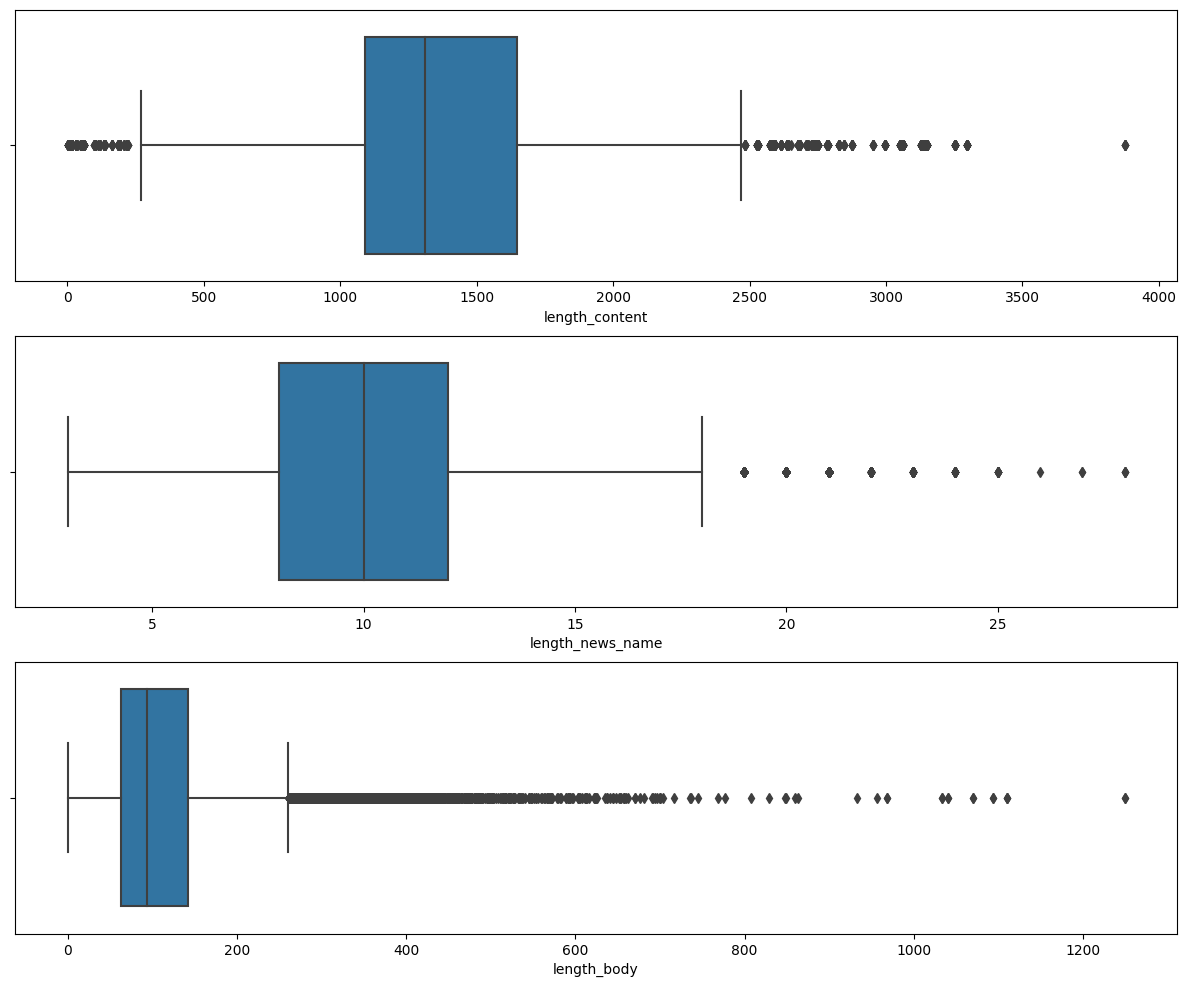

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

sns.boxplot(ax=axes[0], x='length_content', data=data)
sns.boxplot(ax=axes[1], x='length_news_name', data=data)
sns.boxplot(ax=axes[2], x='length_body', data=data)

Необходимо удалить трансляции и тексты новостей, которые слишком длинные или короткие

Трансляция. Нижняя граница:  687.0 , верхняя граница:  2431.0
Текст новости. Нижняя граница:  22.0 , верхняя граница:  366.0


<Axes: xlabel='length_body'>

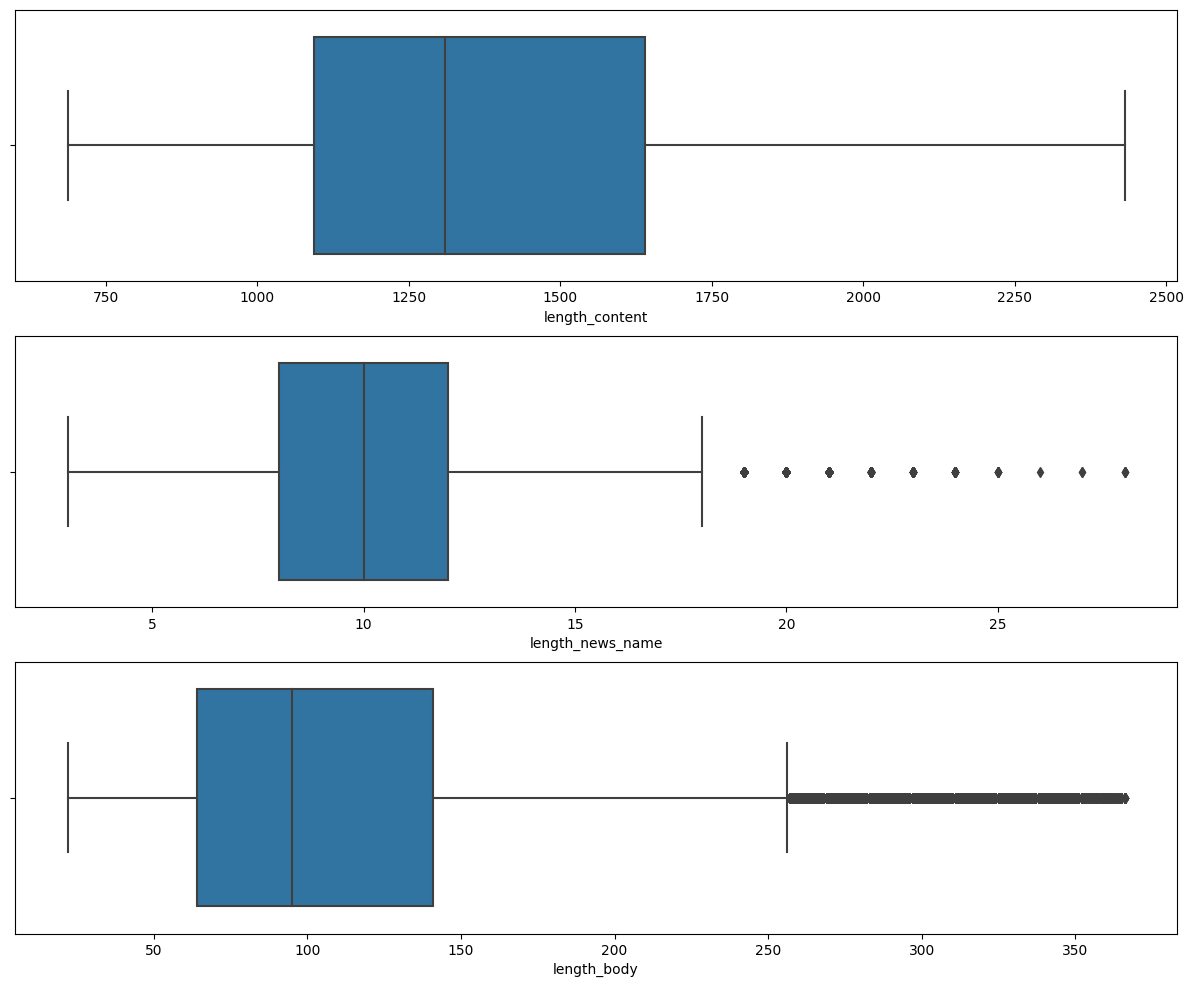

In [ ]:
lower_length_content, upper_length_content = data.length_content.quantile(0.01), data.length_content.quantile(0.99)
lower_length_body, upper_length_body = data.length_body.quantile(0.01), data.length_body.quantile(0.99)

print('Трансляция. Нижняя граница: ', lower_length_content, ', верхняя граница: ', upper_length_content)
data = data.loc[((data['length_content'] >= lower_length_content) & (data['length_content'] <= upper_length_content))]

print('Текст новости. Нижняя граница: ', lower_length_body, ', верхняя граница: ', upper_length_body)
data = data.loc[((data['length_body'] >= lower_length_body) & (data['length_body'] <= upper_length_body))]

fig, axes = plt.subplots(3, 1, figsize=(15, 12))

sns.boxplot(ax=axes[0], x='length_content', data=data)
sns.boxplot(ax=axes[1], x='length_news_name', data=data)
sns.boxplot(ax=axes[2], x='length_body', data=data)

In [ ]:
data[['length_content', 'length_news_name', 'length_body']].describe()

,length_content,length_news_name,length_body
count,89391.000000,89391.000000,89391.000000
mean,1376.112629,10.545681,111.298665
std,366.770723,3.126907,65.119334
min,687.000000,3.000000,22.000000
25%,1093.000000,8.000000,64.000000
50%,1309.000000,10.000000,95.000000
75%,1640.000000,12.000000,141.000000
max,2431.000000,28.000000,366.000000


Количество новостей, которые связаны с трансляцией

<Axes: xlabel='count_news'>

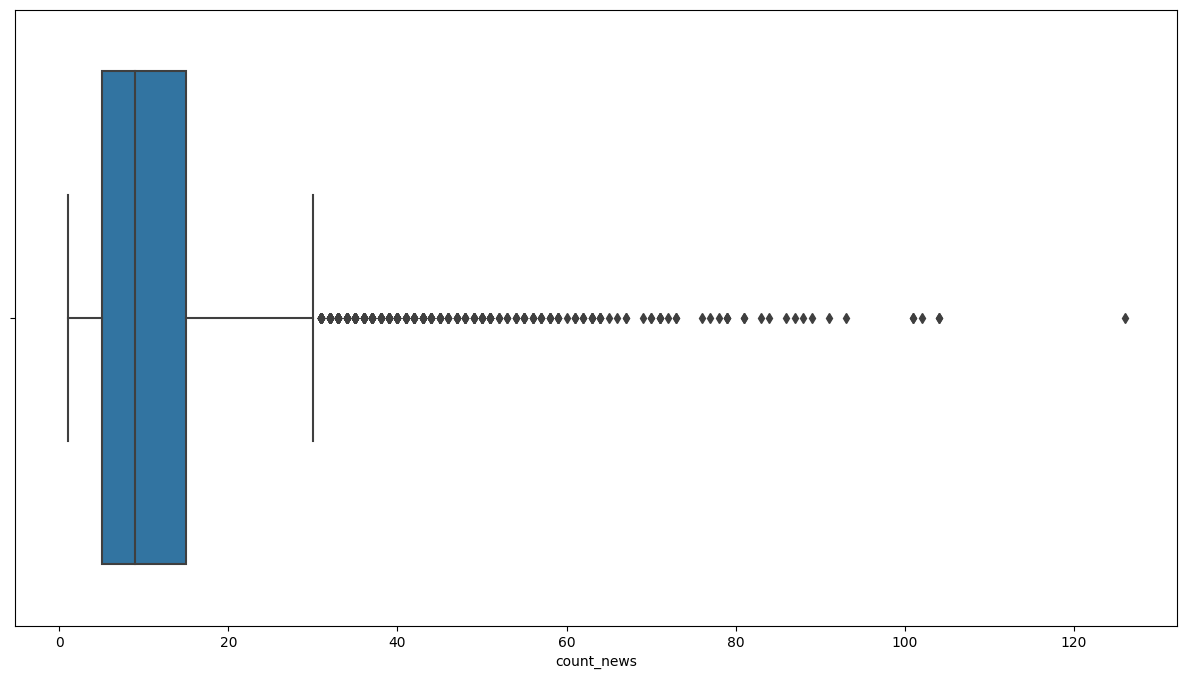

In [ ]:
data_count_news = data.groupby(['match_id']).size().to_frame(name='count_news').reset_index()

plt.figure(figsize=(15, 8))
sns.boxplot(x='count_news', data=data_count_news)

In [ ]:
# Трансляция с наибольшим количеством новостей
max_count_news = data_count_news['count_news'].max()
match_id_with_max_count_news = data_count_news[data_count_news['count_news'] == max_count_news].match_id.values[0]
data[data['match_id'] == match_id_with_max_count_news]

,match_id,team1,team2,broadcast_name,match_time,content,id,news_name,ctime,body,length_content,length_news_name,length_body
11630,219198,Голландия,Испания,перенесенные матчи,2010-07-11 18:30:00,Привет! Финал чемпионата мира! Голландия - Исп...,71726901,"Давид Вилья: «Выиграем финал, если будем держа...",2010-07-10 22:45:06,Нападающий «Барселоны» и сборной Испании Давид...,1709,14,93
11631,219198,Голландия,Испания,перенесенные матчи,2010-07-11 18:30:00,Привет! Финал чемпионата мира! Голландия - Исп...,71727768,"Шакира: «Думаю, что стоит верить осьминогу»",2010-07-10 23:16:57,"Колумбийская певица Шакира рассказал о том, за...",1709,6,125
11632,219198,Голландия,Испания,перенесенные матчи,2010-07-11 18:30:00,Привет! Финал чемпионата мира! Голландия - Исп...,71728206,Снейдер и Стекеленбург смогут сыграть в финале...,2010-07-10 23:39:06,Полузащитник «Интера» и сборной Голландии Уэсл...,1709,8,68
11633,219198,Голландия,Испания,перенесенные матчи,2010-07-11 18:30:00,Привет! Финал чемпионата мира! Голландия - Исп...,71728755,Александр Алиев: «В финале чемпионата мира я б...,2010-07-11 00:08:42,Полузащитник «Локомотива» Александр Алиев заяв...,1709,11,121
11634,219198,Голландия,Испания,перенесенные матчи,2010-07-11 18:30:00,Привет! Финал чемпионата мира! Голландия - Исп...,71730097,Сборная Испании вернется в Мадрид в понедельник,2010-07-11 01:22:57,Сборная Испании вернется с ЧМ-2010 в Мадрид в ...,1709,7,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11752,219198,Голландия,Испания,перенесенные матчи,2010-07-11 18:30:00,Привет! Финал чемпионата мира! Голландия - Исп...,71759817,Александр Мостовой: «Лучший игрок чемпионата м...,2010-07-12 16:18:24,Бывший игрок сборной России Александр Мостовой...,1709,9,187
11753,219198,Голландия,Испания,перенесенные матчи,2010-07-11 18:30:00,Привет! Финал чемпионата мира! Голландия - Исп...,71761256,Йозеф Блаттер: «Игрокам сборных Испании и Голл...,2010-07-12 17:48:18,Президент ФИФА Йозеф Блаттер раскритиковал гру...,1709,12,56
11754,219198,Голландия,Испания,перенесенные матчи,2010-07-11 18:30:00,Привет! Финал чемпионата мира! Голландия - Исп...,71763109,Борис Игнатьев: «Испанцы были чуть предпочтите...,2010-07-12 19:38:14,Тренер московского «Локомотива» Борис Игнатьев...,1709,6,241
11755,219198,Голландия,Испания,перенесенные матчи,2010-07-11 18:30:00,Привет! Финал чемпионата мира! Голландия - Исп...,71763248,Игорь Захаров: «Уэбб не повлиял на результат м...,2010-07-12 19:50:47,Известный в прошлом судья Игорь Захаров подели...,1709,8,309


In [ ]:
data[data['match_id'] == match_id_with_max_count_news].content.values[0]

'Привет! Финал чемпионата мира! Голландия - Испания! Чепчики в воздух! Обе сборные впервые в истории рискуют выиграть титул. Доселе тотальный футбол оранжевых с Круиффом приводил их к серебру в 1974 и 1978 годах. Испанцы же вообще впервые в истории забрались дальше четвертьфинала. При ван Марвейке голландцы не так эффектны, но невероятно эффективны. Победы во всех матчах, начиная с отборочного цикла. Кроме них лишь Новая Зеландия обошлась без поражений на этом первенстве. Испания своей мельтешащей перепасовкой тоже не блещет искрами из-под бутс, зато очень уверенно вгоняет в транс любого соперника, а не только зрителей. Даже великолепная Германия не смогла высвободиться от удушающего сплетенья пиренейских атак. У команды Дель Боске в пассиве только 2 пропущенных мяча, а у голландцев 12 забитых. Не сказал бы, что лед и пламень, но какой-никакой, а нюанс. Говоря о прогнозах на матч, поневоле начинаешь чувствовать себя каким-то головоногим. Ничего, уже скоро креветки можно будет привычно 

#### Изучение категориальных и интервальных признаков

In [ ]:
data['broadcast_name'].value_counts(normalize=True)

Россия. Премьер-лига      0.285543
Лига чемпионов            0.103713
Кубок Гагарина            0.072793
Англия. Премьер-лига      0.066036
КХЛ                       0.061058
                            ...   
Голландия. Высшая лига    0.000034
Беларусь. Суперкубок      0.000022
Экстралига                0.000011
Юношеская лига УЕФА       0.000011
Чемпионат мира U-20       0.000011
Name: broadcast_name, Length: 75, dtype: float64

In [ ]:
print('20 турниров с наибольшим количеством трансляций и новостей: ', data['broadcast_name'].value_counts(normalize=True).head(20).values.sum() * 100., '%')
data['broadcast_name'].value_counts(normalize=True).head(20)

20 турниров с наибольшим количеством трансляций и новостей:  93.9580047208332 %


Россия. Премьер-лига            0.285543
Лига чемпионов                  0.103713
Кубок Гагарина                  0.072793
Англия. Премьер-лига            0.066036
КХЛ                             0.061058
Чемпионат мира                  0.053842
Лига Европы                     0.046761
Испания. Ла Лига                0.037095
Кубок Стэнли                    0.034433
НХЛ                             0.029175
перенесенные матчи              0.027497
Товарищеские матчи (сборные)    0.018861
Квалификация Евро               0.018346
Италия. Серия А                 0.016310
Россия. Олимп Кубок России      0.015113
Чемпионат Европы                0.013480
Олимпийские игры. Хоккей        0.011824
Молодежный Чемпионат Мира       0.011243
Квалификация ЧМ: Европа         0.010135
Украина. Премьер-лига           0.006321
Name: broadcast_name, dtype: float64

<Axes: xlabel='match_time_year', ylabel='count'>

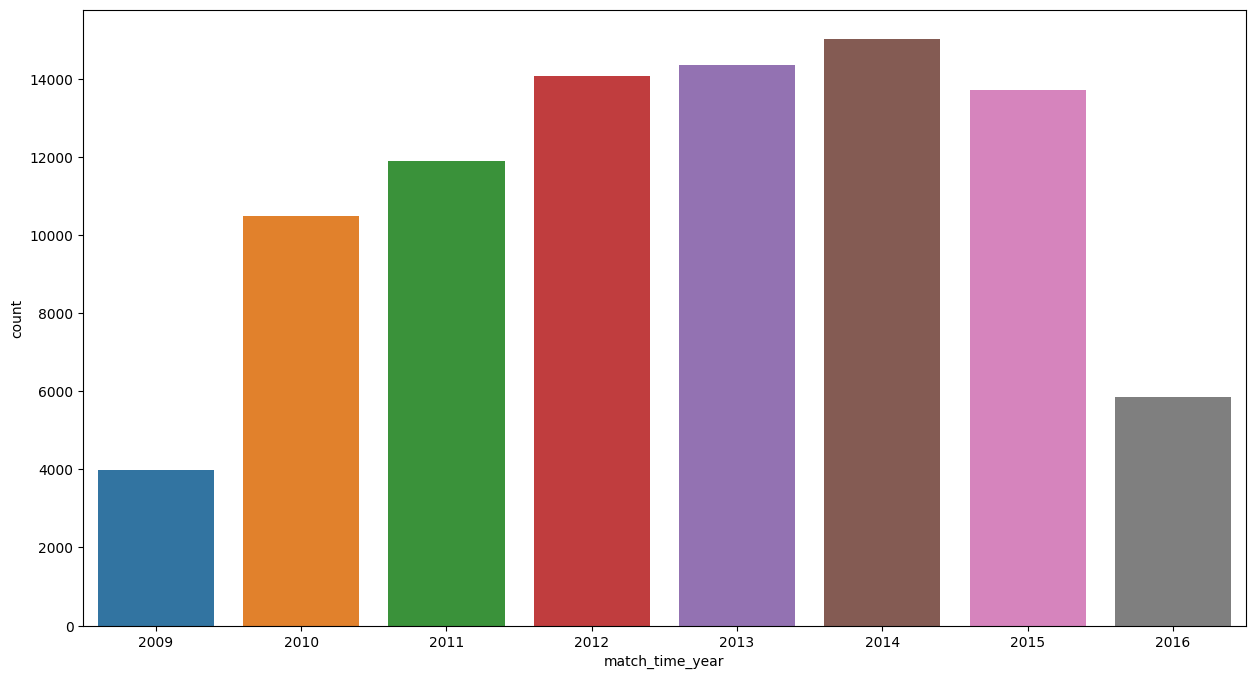

In [ ]:
# Количество опубликованных новостей в год
data['match_time_year'] = pd.DatetimeIndex(data['match_time']).year

plt.figure(figsize=(15, 8))
sns.countplot(x='match_time_year', data=data)

In [ ]:
# сохранение набора данных
data.to_csv('/content/drive/MyDrive/NIR/data.csv', index=False, encoding='utf-8')